# Lab3: Classifiers

In this lab we'll explore a variety of tasks around classification exercise.

The overall goal in this particular example is to

**Develop a tool to predict if a credit card account will default.**

Here is the broad outline of this lab:
1. Load and explore data
1. Assess the relationship among features and target
1. Construct the preprocessing pipeline
1. Train and evaluate one classifier using the metrics discussed in class (confusion matrix, accuracy, precision, recall, ROC curve, etc.).

# Load and explore data

We'll use a credit card defaults simulated dataset for this lab. More details are [here](https://rdrr.io/cran/ISLR/man/Default.html).

The data `Default.csv` is available in the `Slides/Data/` subfolder within the course folder. You can place that in your `Colab Notebooks/BA810/Data/` folder or where ever you want to read it from, mount it and read using `pandas`. Or, you can load using the shared URL.

This lab follows the second approach as it's a little easier.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
file_name = 'https://drive.google.com/uc?export=download&id=13bQQfKDjiuBA1njsvCEW81c4Q2huRE9z'
data = pd.read_csv(file_name)
print('High level data description:')
data.info()
print('\nFirst 3 rows:')
data.head(3)

High level data description:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   default  10000 non-null  object 
 1   student  10000 non-null  object 
 2   balance  10000 non-null  float64
 3   income   10000 non-null  float64
dtypes: float64(2), object(2)
memory usage: 312.6+ KB

First 3 rows:


,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947


The attributes have the following meaning:

* **default**: A categorical variable with levels No and Yes indicating whether the customer defaulted on their debt
* **student**: A categorical variable with levels No and Yes indicating whether the customer is a student
* **balance**: The average balance that the customer has remaining on their credit card after making their monthly payment
* **income**: Income of customer

The dataset has 10,000 rows and all columns have 10,000 non-null values. Thus, we don't have a missing value problem.



Now, examine the variables to get a sense of what is in this dataset.

In [3]:
data.describe() # by default, only summarizes the numeric columns

,balance,income
count,10000.000000,10000.000000
mean,835.374886,33516.981876
std,483.714985,13336.639563
min,0.000000,771.967729
25%,481.731105,21340.462903
50%,823.636973,34552.644802
75%,1166.308386,43807.729272
max,2654.322576,73554.233495


In [4]:
print(data.describe(include=object)) # check the categorical variables
print('\n')
print(data.select_dtypes(include='object').apply(lambda x: x.value_counts()))


       default student
count    10000   10000
unique       2       2
top         No      No
freq      9667    7056


     default  student
No      9667     7056
Yes      333     2944


Both categorical features have two unique values.

The `default` statistics shows an extremely skewed class distribution: ≈97% are non-defaults. We'll see how to handle such cases towards the end of the course. For now, we need to keep this in mind as we pick an evaluation metric.

The `student` column is more balanced, with majority being non-students.

# Logistic Regression

We'll briefly use Logistic Regression to examine the association between explanatory variables (student, balance, and income) and the outcome (default). We can use `statsmodels` for it.

Logistic regression is part of a broader class of models known as the Generalized Linear Models. We can use the `glm()` routine to fit any of these. To fit a Logistic Regression, we need to also let the routine know that the outcome is binary.

In [5]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

data_enc = data.copy()

# Convert the categorical columns to binary, to ensure correct interpretation of the coefficients.
data_enc['default'] = data_enc['default'].map({'Yes': 1, 'No': 0})
data_enc['student'] = data_enc['student'].map({'Yes': 1, 'No': 0})

# Create and fit the generalized linear model
model = smf.logit(formula='default ~ student + balance + income', data=data_enc)
result = model.fit(disp=0)  # silence some unneeded estimation information

# Print the summary statistics
print(result.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -10.8690      0.492    -22.079      0.000     -11.834      -9.904
student       -0.6468      0.236     -2.738      0.006      -1.110      -0.184
balance        0.0057      0.000     24.737      0.000       0.005       0.006
income      3.033e-06    8.2e-06      0.370      0.712    -1.3e-05    1.91e-05


We find that
1. Students have a significantly lower risk of default.
1. With higher balance the risk of default is higher. Specifically, for every $1 increase in balance, the odd-ratio of default increases by 0.57%.
1. Income doesn't seem to have any (statistically significant) association.

If the odds-ratio is hard to interpret, we can convert it to the change in probability of default for unit change in the explanatory variables ("marginal effects").

In [6]:
print(result.get_margeff().summary())

        Logit Marginal Effects       
Dep. Variable:                default
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
student       -0.0139      0.005     -2.735      0.006      -0.024      -0.004
balance        0.0001   4.85e-06     25.398      0.000       0.000       0.000
income      6.517e-08   1.76e-07      0.370      0.711    -2.8e-07     4.1e-07


Students are 1.4% less likely to default. This may seem small, but relative to a baseline default rate of 3.3%, this is a huge effect!

Each dollar increase in balance increases the risk of default by 0.01%. This doesn't seem like a big effect, but the baseline default rate is small. There is one other factor to consider: perhaps it's more meaningful to consider changes in balance in 100s of dollars instead of single dollars. For every $100 increase in credit card balance the risk of default increases by ≈1%. This is a significant effect over a baseline rate of 3.3%.

As before, income doesn't seem to have a significant effect.

# Train and evaluate a classifier to predict `Default`

Let's separate the X from y: scikit learn methods often take them as separate arguments. Let's also set aside some data for testing so that we can estimate the generalization error.

In [7]:
from sklearn.model_selection import train_test_split

# separate X from y
X = data.drop("default", axis=1)
y = data["default"]

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# check
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7500, 3), (2500, 3), (7500,), (2500,))

## Construct the Pipeline

Now let's build our preprocessing pipeline.

数据预处理管道：数值型变量标准化；分类变量one-hot编码；分列处理器

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn import set_config
set_config(display='diagram') # shows the pipeline structure graphically

cat_attribs = ["student"]
num_attribs = ["balance", "income"]

preprocess_pipeline = ColumnTransformer([ # handle each type of column with appropriate pipeline
        ("cat", OneHotEncoder(drop="first"), cat_attribs),
        ("num", StandardScaler(), num_attribs),
    ])

preprocess_pipeline

ColumnTransformer(transformers=[('cat', OneHotEncoder(drop='first'),
                                 ['student']),
                                ('num', StandardScaler(),
                                 ['balance', 'income'])])

Cool! Now we have a nice preprocessing pipeline that takes the raw data and outputs numerical input features that we can feed to any Machine Learning model we want.

In [9]:
X_train_transformed = preprocess_pipeline.fit_transform(X_train)
print('   Original data ')
print(X_train.head(), '\n')
print('   Transformed data ')
print(X_train_transformed[:5,:], '\n')
preprocess_pipeline.get_feature_names_out() # check the column names produced by the pipeline

   Original data 
     student      balance        income
2967      No  1008.946540  31235.782923
700       No  1060.807429  39174.056361
3481     Yes  1971.663236  22040.262741
1621      No   114.884475  27365.422200
800       No     0.000000  31083.221457 

   Transformed data 
[[ 0.          0.36630752 -0.1757258 ]
 [ 0.          0.47396683  0.42065672]
 [ 1.          2.36483509 -0.86656211]
 [ 0.         -1.48969819 -0.46649627]
 [ 0.         -1.72818973 -0.18718736]] 



array(['cat__student_Yes', 'num__balance', 'num__income'], dtype=object)

## Train and evaluate a few classifiers

We are now ready to train a classifier. Let's start with a `LogisticRegression`. Although we can apply the preprocessing pipeline defined above to training data and fit, then apply the same to test data and fit again, encapsulating the process in pipeline is easier and less error prone.

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

lr_pipe = make_pipeline(preprocess_pipeline, LogisticRegression())
lr_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['student']),
                                                 ('num', StandardScaler(),
                                                  ['balance', 'income'])])),
                ('logisticregression', LogisticRegression())])

Great, our model is trained, let's use it to make predictions on the test set:

In [11]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score

y_pred = lr_pipe.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred):.3f}')

Accuracy: 0.971


That seems high. Remember how skewed the class labels were? Let's print the balanced accuracy (the average of positive and negative recall).

In [12]:
print(f'Balanced accuracy: {balanced_accuracy_score(y_test, y_pred):.3f}')

Balanced accuracy: 0.655


This is more modest and realistic measurement of the classifier's performance.

We also saw several other classification metrics such as confusion matrix, precision, recall, F-measure, etc. Let's compute them, starting with the confusion matrix:

In [13]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
# print(lr_pipe.classes_)

[[2397    7]
 [  66   30]]


Remember rows hold the true labels and columns the predicted labels. First label is 'No' and the second is 'Yes' (can be verified by printing the classes in the fitted model:`lr_pipe.classes_`).

So, the predictive model is confusing 66 of the 96 positive records as negative (lower left) and 7 negatives to be positives (upper right). The printed confusion matrix above is a bit bare (no row column labels). You can dress it up by using `ConfusionMatrixDisplay`.

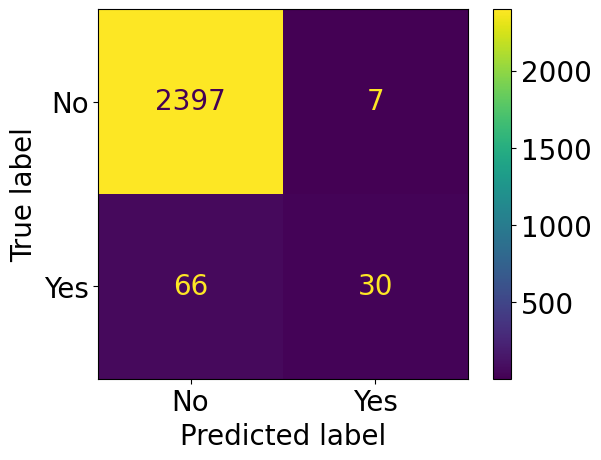

In [14]:
import matplotlib as mpl
from sklearn.metrics import ConfusionMatrixDisplay
mpl.rcParams['font.size'] = 20 # default fonts were too small -- enlarge
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);
mpl.rcdefaults()  # reset the font sizes for the next plot

Let's turn briefly to direct precision, recall, and F-score calculation as discussed in the class. I.e., a precision is the fraction of *positive* records returned by the classifier, recall is the fraction of all *positive* records returned, and F-measure is the geometric mean of the two. In order to calculate, the relevant sklearn routines need to know which is the positive class. As it stands now, it doesn't know which of the two lables -- 'No' and 'Yes' -- we consider positive. We have to tell it explicitly. Without this it assumes a default of label 1, which may not even occur in a target column (for example ours).

Here is how we can compute these scores with our data:

In [15]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

precision = precision_score(y_test, y_pred, pos_label="Yes")
recall = recall_score(y_test, y_pred, pos_label="Yes")
f1 = f1_score(y_test, y_pred, pos_label="Yes")

print(f'Precision={precision:.4f}, Recall={recall:.4f}, F1-score={f1:.4f}')

Precision=0.8108, Recall=0.3125, F1-score=0.4511


The `classification_report()` gives class by class precision, recall, and f-measure, along with the averages over all the classes (No and Yes in this problem). Since it computes precision and recall for each class, it doesn't need to be told which is positive: it considers each positive in turn and computes the resulting scores.

In [16]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

          No      0.973     0.997     0.985      2404
         Yes      0.811     0.312     0.451        96

    accuracy                          0.971      2500
   macro avg      0.892     0.655     0.718      2500
weighted avg      0.967     0.971     0.965      2500



The **support** column shows the number of records with the actual class labels. So, the precision, recall, and F-measure for the line labeled 'No', are based on the records in the test data that had label 'No' on them (and there are (2397+7=2404) such records).

The last two lines average these measures across the two classes. The **macro average** gives each group equal weight, whereas the **weighted average** (aka **micro average**) gives each group weight equal to the number of records in it. Notice how the weighted averages suffer from the same problem as accuracy: they all show high numbers because of good performance on easy to predict 'No' class.

On the other hand, the macro averages show a more realistic and useful score here by giving equal weights to the two classes. It's no coincidence that the macro average of the recalls is same as the balanced accuracy we saw a few blocks ago: they are the same.

The [Chapter 3.3](https://scikit-learn.org/stable/modules/model_evaluation.html) in Scikit-learn user guide has many more metrics with examples.


We also discussed the ROC curve. One can plot it using the `RocCurveDisplay.from_estimator()` function:

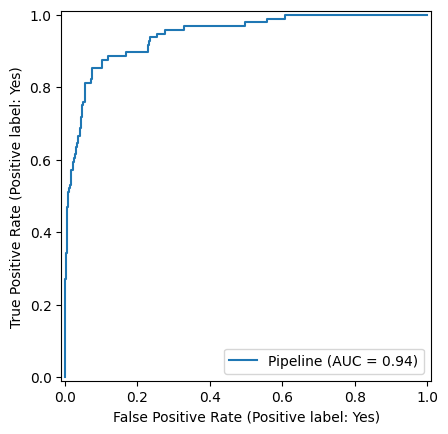

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(lr_pipe, X_test, y_test);

See the [scikit-learn visualization guide](https://scikit-learn.org/stable/visualizations.html) and the section on [ROC curve](https://scikit-learn.org/stable/modules/model_evaluation.html#receiver-operating-characteristic-roc) for more.

***
**Exercises**:

1. Evaluate the `KNeighborsClassifier` and `RandomForestClassifier`. Which of the three classifiers considered in this lab seems to perform best?

  Note, you can further tune each of these classifiers -- check from their documentation some of the arguments they take. How to do that in an automated and scientific way is the topic of a future class.

2. What is Precision-Recall curve? Can you plot it next to the ROC curve using scikit learn?

***